# Which advertisements are worth their cost?

## imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hypertools as hyp
from glob import glob as lsdir
from scipy.stats import pearsonr
import os
import re
import joblib
import pickle
import datetime as dt

from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

%matplotlib inline

/optnfs/el7/jupyterhub/envs/Psych81.09/lib/python3.6/site-packages/hypertools/plot/__init__.py:10: UserWarning: Could not switch backend to TkAgg.  This may impact performance of the plotting functions.
  warnings.warn('Could not switch backend to TkAgg.  This may impact performance of the plotting functions.')


## load data

In [2]:
data_readers = {'xlsx': pd.read_excel, 'xls': pd.read_excel, 'dta': pd.read_stata}
get_extension = lambda x: x.split('.')[-1]

In [3]:
def read_data(datadir, readers):
    files = lsdir(os.path.join(datadir, '*'))
    readable_files = []
    data = []
    for f in files:
        ext = get_extension(f)
        if ext in readers.keys():
            readable_files.append(f)
            data.append(data_readers[ext](f))
    return readable_files, data

In [4]:
fnames, data = read_data('data', data_readers)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


### remove excess rows

In [5]:
data[2] = data[2][:24]

### merged data[1] and data[3]

In [6]:
with open('merged_df.p', 'rb') as f:
    data1_3_merged = pickle.load(f)

### add 2nd sheet from Direct Mailing Analysis.xlsx (2019)

In [7]:
mailing_donations = pd.read_excel('data/Direct Mailing Analysis.xlsx', sheet_name=1).replace(
    {'Defense of Wildlife' : 'defenders of wildlife', 'National Grographic' : 'National Geographic',
    'National Parks & Cons. ': 'national parks'})
                                                                                              
mailing_donations.LIST = mailing_donations.LIST.apply(lambda x: x.upper())

## manually load listing cost data

In [8]:
listings = ['Appalachian Mountain club primary', 'Appalachian Mountain club secondary', 'backpacker magazine', 
            'birds & blooms magazine', 'Cabela’s camping', 'campmor camping/climbing buyers', 
            'defenders of wildlife', 'Duncraft catalog', 'environmental Defense fund', 
            'Audubon', 
            'National Geographic', 'national parks', 
            'national resources defense', 'NWF',
            'nature conservancy', 'ocean conservancy',
            'sierra club', 'the New Yorker', 'wilderness Society', 
            'world wildlife fund', 'Adirondack life']

listings = list(map(str.upper, listings))

In [9]:
list_costs = [0.00, 0.00, 10.01, 27.61, 0.00, 0.00, 26.11, 10.06, 14.20, 42.50, 60.33, 36.61, 0.00, 
              39.51, 92.27, 8.91, 27.51, 92.43, 14.34, 24.95, 0.00]

In [10]:
cost_df = pd.DataFrame({'LIST' : listings, 'COST': list_costs})

# how much in donations did each listing generate?

In [11]:
gain_df = mailing_donations.groupby('LIST').sum().reset_index()

In [12]:
cost_df.head()

,COST,LIST
0,0.00,APPALACHIAN MOUNTAIN CLUB PRIMARY
1,0.00,APPALACHIAN MOUNTAIN CLUB SECONDARY
2,10.01,BACKPACKER MAGAZINE
3,27.61,BIRDS & BLOOMS MAGAZINE
4,0.00,CABELA’S CAMPING


In [13]:
gain_df.head()

,LIST,ID,Town,AMOUNT,CODE
0,AUDUBON,46208,96,200,904605
1,DEFENDERS OF WILDLIFE,45982,60,75,542748
2,DUNCRAFT CATALOG,11350,12,1000,180917
3,NATIONAL GEOGRAPHIC,21361,41,70,361846
4,NATIONAL PARKS,32989,55,85,542772


In [14]:
cost_gain = cost_df.merge(gain_df, how='left').fillna(0)

In [16]:
cost_gain

,COST,LIST,ID,Town,AMOUNT,CODE
0,0.00,APPALACHIAN MOUNTAIN CLUB PRIMARY,0.0,0.0,0.0,0.0
1,0.00,APPALACHIAN MOUNTAIN CLUB SECONDARY,0.0,0.0,0.0,0.0
2,10.01,BACKPACKER MAGAZINE,0.0,0.0,0.0,0.0
3,27.61,BIRDS & BLOOMS MAGAZINE,0.0,0.0,0.0,0.0
4,0.00,CABELA’S CAMPING,0.0,0.0,0.0,0.0
5,0.00,CAMPMOR CAMPING/CLIMBING BUYERS,0.0,0.0,0.0,0.0
6,26.11,DEFENDERS OF WILDLIFE,45982.0,60.0,75.0,542748.0
7,10.06,DUNCRAFT CATALOG,11350.0,12.0,1000.0,180917.0
8,14.20,ENVIRONMENTAL DEFENSE FUND,0.0,0.0,0.0,0.0
9,42.50,AUDUBON,46208.0,96.0,200.0,904605.0


/optnfs/el7/jupyterhub/envs/Psych81.09/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/optnfs/el7/jupyterhub/envs/Psych81.09/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


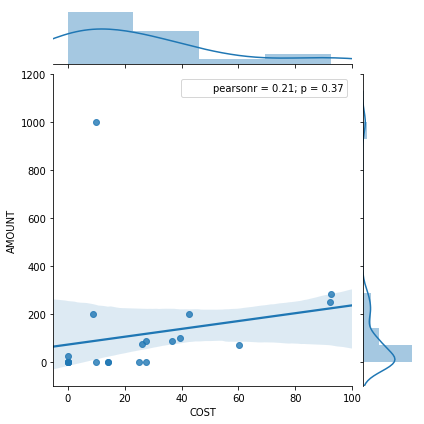

In [15]:
sns.jointplot(cost_gain['COST'], cost_gain['AMOUNT'], kind='reg', stat_func=pearsonr,
              xlim=(-5,100), ylim=(-100,1200))

# The 1000-dollar point is a single, huge donation

In [16]:
# try removing it
dunc_dropped = cost_gain.drop(7)

/optnfs/el7/jupyterhub/envs/Psych81.09/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


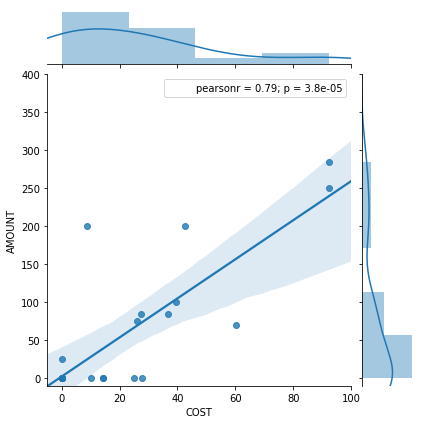

In [17]:
sns.jointplot(dunc_dropped['COST'], dunc_dropped['AMOUNT'], kind='reg', stat_func=pearsonr, 
              xlim=(-5,100), ylim=(-10,400))